In [1]:
import glob

import torch
import numpy as np
from scipy.io import loadmat
from scipy.signal import resample

from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.encdec import *
from timedenoiser.models.unet import UNET_1D
from timedenoiser.models.ekf import ekf
from timedenoiser.models.tv1d import tv
from timedenoiser.models.wt import wt

from motormetrics.ml import *
from motormetrics.ee import *
from motormetrics.ee import get_ramp_from_sim_reference

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_ud = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_uq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')

# model_id = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

# model_id = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.01_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_id.eval()
model_iq.eval()
model_ud.eval()
model_uq.eval()

model_spd = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd.eval()
model_trq.eval()

model_spd_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd_n.eval()
model_trq_n.eval()

ShallowEncDec(
  (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
  (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
  (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
  (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
  (act): ReLU()
)

In [3]:
class Exper():
        def __init__(self, kwargs):
            for k in kwargs:
                self.__dict__[k] = kwargs[k]
                
def compute_ml(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    print ('Speed')
    print ('SMAPE :', smape(speed_pred, ndata['speed']))
    print ('R2 :', r2(speed_pred, ndata['speed']))
    print ('RMSE :', rmse(speed_pred, ndata['speed']))
    print ('MAE :', mae(speed_pred, ndata['speed']))

    print ('Torque')
    print ('SMAPE :', smape(torque_pred, ndata['torque']))
    print ('R2 :', r2(torque_pred, ndata['torque']))
    print ('RMSE :', rmse(torque_pred, ndata['torque']))
    print ('MAE :', mae(torque_pred, ndata['torque']))
    
def compute_ee(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    ndata['speed'] = speed_pred
    ndata['torque'] = torque_pred
    model_exp = Exper(ndata)

    model_torque_metrics = compute_torque_metrics(model_exp)
    model_speed_metrics = compute_speed_metrics(model_exp)

    print (model_speed_metrics)
    print (model_torque_metrics)

In [4]:
data1 = loadmat('../../../datasets/Data_27012021_noisy/benchmark/real1.mat')
data2 = loadmat('../../../datasets/Data_27012021_noisy/real/OFVC4kW_NoLM_SpeedVariations_20190419_Data.mat')

st = 0
et = -1

x_id = np.stack([data2['noisy_current_d'][0] / 30]) 
x_iq = np.stack([data2['noisy_current_q'][0] / 30])
x_ud = np.stack([data2['noisy_voltage_d'][0] / 300]) 
x_uq = np.stack([data2['noisy_voltage_q'][0] / 300])

x_d = np.stack([[x_id[0], x_iq[0], x_ud[0], x_uq[0]]])


inp_id = torch.tensor([x_id[:, st:et]]).cuda().float()
out_id = model_id(inp_id)
out_id_da = out_id.data.cpu().numpy()[0]
out_id_wt = wt(data2['noisy_current_d'][0], 0.17)
out_id_ekf = ekf(data2['noisy_current_d'][0], 0.17)
out_id_tv = tv(data2['noisy_current_d'][0], 0.17)

inp_iq = torch.tensor([x_iq[:, st:et]]).cuda().float()
out_iq = model_iq(inp_iq)
out_iq_da = out_iq.data.cpu().numpy()[0]
out_iq_wt = wt(data2['noisy_current_q'][0], 0.29)
out_iq_ekf = ekf(data2['noisy_current_q'][0], 0.29)
out_iq_tv = tv(data2['noisy_current_q'][0], 0.29)

inp_ud = torch.tensor([x_ud[:, st:et]]).cuda().float()
out_ud = model_ud(inp_ud)
out_ud_da = out_ud.data.cpu().numpy()[0]
out_ud_wt = wt(data2['noisy_voltage_d'][0], 1.85)
out_ud_ekf = ekf(data2['noisy_voltage_d'][0], 1.85)
out_ud_tv = tv(data2['noisy_voltage_d'][0], 1.85)

inp_uq = torch.tensor([x_uq[:, st:et]]).cuda().float()
out_uq = model_uq(inp_uq)
out_uq_da = out_uq.data.cpu().numpy()[0]
out_uq_wt = wt(data2['noisy_voltage_q'][0], 1.78)
out_uq_ekf = ekf(data2['noisy_voltage_q'][0], 1.78)
out_uq_tv = tv(data2['noisy_voltage_q'][0], 1.78)

inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                       out_iq_da[0], 
                                       out_ud_da[0], 
                                       out_uq_da[0]]])).cuda()
inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                       out_iq_wt / 30, 
                                       out_ud_wt / 300, 
                                       out_uq_wt / 300]])).cuda().float()
inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                       out_iq_ekf / 30, 
                                       out_ud_ekf / 300, 
                                       out_uq_ekf / 300]])).cuda().float()
inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                       out_iq_tv / 30, 
                                       out_ud_tv / 300, 
                                       out_uq_tv / 300]])).cuda().float()
inps_d = torch.from_numpy(x_d).cuda().float()

out_spd_da = model_spd(inps_da)
out_spd_da = out_spd_da.data.cpu().numpy()[0]
out_spd_wt = model_spd(inps_wt)
out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
out_spd_ekf = model_spd(inps_ekf)
out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
out_spd_tv = model_spd(inps_tv)
out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
out_spd_d = model_spd_n(inps_d)
out_spd_d = out_spd_d.data.cpu().numpy()[0]

out_trq_da = model_trq(inps_da)
out_trq_da = out_trq_da.data.cpu().numpy()[0]
out_trq_wt = model_trq(inps_wt)
out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
out_trq_ekf = model_trq(inps_ekf)
out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
out_trq_tv = model_trq(inps_tv)
out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
out_trq_d = model_trq(inps_d)
out_trq_d = out_trq_d.data.cpu().numpy()[0]






In [5]:
alpha = 0.1
speed_pred_d = out_spd_d[0] * 80
speed_pred_d = alpha * speed_pred_d + (1 - alpha) * data2['speed'][0]

torque_pred_d = out_trq_d[0] * 120
torque_pred_d = alpha * torque_pred_d + (1 - alpha) * data2['torque'][0]

alpha = 0.01
speed_pred_md = np.copy(data2['speed'][0])
speed_pred_md[:-1] = out_spd_da[0] * 80
speed_pred_md = alpha * speed_pred_md + (1 - alpha) * data2['speed'][0]

torque_pred_md = np.copy(data2['torque'][0])
torque_pred_md[:-1] = out_trq_da[0] * 120
torque_pred_md = alpha * torque_pred_md + (1 - alpha) * data2['torque'][0]


alpha = 0.09
speed_pred_da = np.copy(data2['speed'][0])
speed_pred_da[:-1] = out_spd_da[0] * 80
speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data2['speed'][0]

torque_pred_da = np.copy(data2['torque'][0])
torque_pred_da[:-1] = out_trq_da[0] * 120
torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data2['torque'][0]

alpha = 0.14
speed_pred_wt = out_spd_wt[0] * 80
speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data2['speed'][0]

torque_pred_wt = out_trq_wt[0] * 120
torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data2['torque'][0]

alpha = 0.15
speed_pred_ekf = out_spd_ekf[0] * 80
speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data2['speed'][0]

torque_pred_ekf = out_trq_ekf[0] * 120
torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data2['torque'][0]

alpha = 0.1
speed_pred_tv = out_spd_tv[0] * 80
speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data2['speed'][0]

torque_pred_tv = out_trq_tv[0] * 120
torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data2['torque'][0]

dict_keys(['__header__', '__version__', '__globals__', 'voltage_d', 'voltage_q', 'current_d', 'current_q', 'torque', 'speed', 'statorPuls', 'time', 'reference_torque_interp', 'reference_speed_interp', 'reference_torque', 'reference_speed', 'torque_time', 'speed_time', 'noisy_current_d', 'noisy_current_q', 'noisy_voltage_d', 'noisy_voltage_q'])
--------- Real Sim-----------
{'perc2_times': [0.06], 'perc95_times': [1.184], 'following_errs': [0.1102], 'following_times': [4.764], 'overshoot_errs': [3.4206], 'overshoot_times': [5.488], 'ramp_start_times': [4.136], 'sse_errs': [-0.0183], 'sse_times': [6.796], 'max_trq_accs': [9.8976], 'max_trq_acc_times': [4.304]}
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'speed_drops': [], 'speed_drops_times': []}
--------- Real Motor-----------
{'perc2_times': [0.024], 'perc95_times': [1.156], 'following_errs': [-

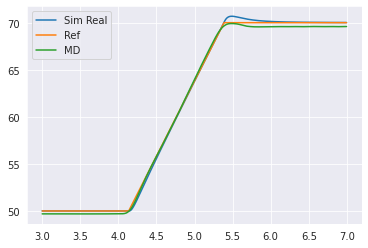

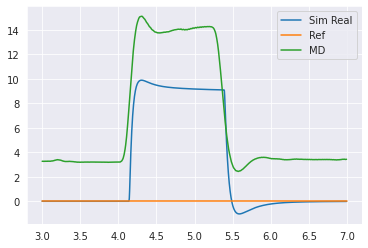

In [8]:
st1 = int(3 / 0.004)
et1 = int(7 / 0.004)

st2 = int(2.658 / 0.004)
et2 = int(6.101 / 0.004)

data1n = {}
for k in data1.keys():
    if '__' not in k:
        data1n[k] = data1[k][:, st1:et1]
    
print (data1.keys())
data1n['reference_speed'] = data1['reference_speed']
data1n['reference_torque'] = data1['reference_torque']
data1n['speed_time'] = np.asarray([[ 3.0, 4.136, 5.388, 6.996]])
data1n['torque_time'] = np.asarray([[ 3.0, 4.136, 5.388, 6.996]])




print ('--------- Real Sim-----------')
compute_ee(data1n, data1n['speed'][0], data1n['torque'][0])

print ('--------- Real Motor-----------')
compute_ee(data1n, data2['speed'][0][st1-0:et1-0], data2['torque'][0][st1-0:et1-0])

print ('--------- Case D ----------')
compute_ee(data1n, speed_pred_d[st1-0:et1-0], torque_pred_d[st1-0:et1-0])

print ('--------- WT ----------')
compute_ee(data1n, speed_pred_wt[st1-0:et1-0], torque_pred_wt[st1-0:et1-0])

print ('--------- EKF ----------')
compute_ee(data1n, speed_pred_ekf[st1-0:et1-0], torque_pred_ekf[st1-0:et1-0])

print ('--------- TV -----------')
compute_ee(data1n, speed_pred_tv[st1-0:et1-0], torque_pred_tv[st1-0:et1-0])

print ('--------- DA ----------')
compute_ee(data1n, speed_pred_da[st1-0:et1-0], torque_pred_da[st1-0:et1-0])

print ('--------- MD ----------')
compute_ee(data1n, speed_pred_md[st1-0:et1-0], torque_pred_md[st1-0:et1-0])

plt.plot(data1n['time'][0], data1n['speed'][0], label='Sim Real')
plt.plot(data1n['time'][0], data1n['reference_speed_interp'][0], label='Ref')
plt.plot(data1n['time'][0], speed_pred_da[st1-0:et1-0], label='MD')
plt.legend()
plt.show()

plt.plot(data1n['time'][0], data1n['torque'][0], label='Sim Real')
plt.plot(data1n['time'][0], data1n['reference_torque_interp'][0], label='Ref')
plt.plot(data1n['time'][0], torque_pred_da[st1-0:et1-0], label='MD')
plt.legend()
plt.show()

In [12]:
st1 = int(3 / 0.004)
et1 = int(7 / 0.004)

st2 = st1
et2 = et1

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2], data2['noisy_current_d'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['current_d'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], (0.5 * out_id_da[0][st2:et2] * 30 + 0.5 * out_id_tv[st2:et2]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_id.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2], data2['noisy_current_q'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['current_q'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_iq_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], (0.5 * out_iq_da[0][st2:et2] * 30 + 0.5 * out_iq_tv[st2:et2]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$i_q$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_iq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2], data2['noisy_voltage_d'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['voltage_d'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], (0.5 * out_ud_da[0][st2:et2] * 300 + 0.5 * out_ud_tv[st2:et2]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$u_d$ (V)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
# plt.show()
plt.savefig('real1_ud.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2], data2['noisy_voltage_q'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['voltage_q'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_iq_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], (0.5 * out_uq_da[0][st2:et2] * 300 + 0.5 * out_uq_tv[st2:et2]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$u_q$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_uq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data1['time'][0, st1:et1], data1['reference_speed_interp'][0, st1:et1], 'k--', label="Ref", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['speed'][0, st1:et1], 'k', label="Sim Real")
plt.plot(data2['time'][0, st2:et2], data2['noisy_speed'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
plt.plot(data2['time'][0, st2:et2], data2['speed'][0, st2:et2], 'g--', label="Motor Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], speed_pred_d[st2:et2], 'y', label="DiagBiRNN Case D", alpha=1)
plt.plot(data2['time'][0, st2:et2], speed_pred_md[st2:et2], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\omega_r$ (Hz))', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_spd.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data1['time'][0, st1:et1], data1['reference_torque_interp'][0, st1:et1], 'k--', label="Ref", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['torque'][0, st1:et1], 'k', label="Sim Real")
plt.plot(data2['time'][0, st2:et2], data2['noisy_torque'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
plt.plot(data2['time'][0, st2:et2], data2['torque'][0, st2:et2], 'g--', label="Motor Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], torque_pred_d[st2:et2], 'y', label="DiagBiRNN Case D", alpha=1)
plt.plot(data2['time'][0, st2:et2], torque_pred_md[st2:et2], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nom))', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_trq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

st1 = int(3.5 / 0.004)
et1 = int(4.5 / 0.004)

st2 = st1
et2 = et1

sns.set_style("darkgrid")
plt.plot(data1['time'][0, st1:et1], data1['reference_speed_interp'][0, st1:et1], 'k--', label="Ref", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['speed'][0, st1:et1], 'k', label="Sim Real")
plt.plot(data2['time'][0, st2:et2], data2['noisy_speed'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
plt.plot(data2['time'][0, st2:et2], data2['speed'][0, st2:et2], 'g--', label="Motor Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], speed_pred_d[st2:et2], 'y', label="DiagBiRNN Case D", alpha=1)
plt.plot(data2['time'][0, st2:et2], speed_pred_md[st2:et2], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\omega_r$ (Hz))', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_spd1.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()


st1 = int(5 / 0.004)
et1 = int(6.3 / 0.004)

st2 = st1
et2 = et1

sns.set_style("darkgrid")
plt.plot(data1['time'][0, st1:et1], data1['reference_speed_interp'][0, st1:et1], 'k--', label="Ref", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['speed'][0, st1:et1], 'k', label="Sim Real")
plt.plot(data2['time'][0, st2:et2], data2['noisy_speed'][0, st2:et2], 'g', label="Motor Noisy", alpha=0.3)
plt.plot(data2['time'][0, st2:et2], data2['speed'][0, st2:et2], 'g--', label="Motor Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2], speed_pred_d[st2:et2], 'y', label="DiagBiRNN Case D", alpha=1)
plt.plot(data2['time'][0, st2:et2], speed_pred_md[st2:et2], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\omega_r$ (Hz))', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real1_spd2.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()